In [22]:
pip install datasets==2.14.4 fsspec==2023.6.0


In [23]:
 from datasets import load_dataset

# Load the verified working dataset
dataset = load_dataset("frankdarkluo/dailydialog")

# Preview structure
print(dataset)
print(dataset["train"][0])


DatasetDict({
    train: Dataset({
        features: ['context', 'response'],
        num_rows: 60005
    })
    validation: Dataset({
        features: ['context', 'response'],
        num_rows: 6594
    })
    test: Dataset({
        features: ['context', 'response'],
        num_rows: 6955
    })
})
{'context': 'Waiter ! ', 'response': " I'll be with you in a second . Uh ... Yes , ma'am ? "}


In [24]:
# Auto-Label Responses with Sentiment
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

# Load a pre-trained Twitter sentiment model
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
classifier = pipeline("sentiment-analysis", model=model_name, tokenizer=model_name)

# Annotate the first 5 responses
for i in range(5):
    text = dataset["train"][i]["response"]
    result = classifier(text)[0]
    print(f"Response: {text}")
    print(f"Predicted Sentiment: {result['label']} (score: {result['score']:.2f})")
    print("---")


Device set to use cpu


Response:  I'll be with you in a second . Uh ... Yes , ma'am ? 
Predicted Sentiment: LABEL_1 (score: 0.78)
---
Response:  This is not what I asked for . I'm afraid . 
Predicted Sentiment: LABEL_0 (score: 0.92)
---
Response:  Oh , I'm so sorry . May I ask what you ordered again ? 
Predicted Sentiment: LABEL_0 (score: 0.72)
---
Response:  Yes . What I ordered is roast beef , not roast beef sandwiches . 
Predicted Sentiment: LABEL_1 (score: 0.68)
---
Response:  Mind your own business . 
Predicted Sentiment: LABEL_1 (score: 0.59)
---


In [26]:
label_map = {
    "LABEL_0": "Negative",
    "LABEL_1": "Neutral",
    "LABEL_2": "Positive"
}

for i in range(5):
    text = dataset["train"][i]["response"]
    result = classifier(text)[0]
    sentiment = label_map[result['label']]
    print(f"Response: {text}")
    print(f"Predicted Sentiment: {sentiment} (score: {result['score']:.2f})")
    print("---")


Response:  I'll be with you in a second . Uh ... Yes , ma'am ? 
Predicted Sentiment: Neutral (score: 0.78)
---
Response:  This is not what I asked for . I'm afraid . 
Predicted Sentiment: Negative (score: 0.92)
---
Response:  Oh , I'm so sorry . May I ask what you ordered again ? 
Predicted Sentiment: Negative (score: 0.72)
---
Response:  Yes . What I ordered is roast beef , not roast beef sandwiches . 
Predicted Sentiment: Neutral (score: 0.68)
---
Response:  Mind your own business . 
Predicted Sentiment: Neutral (score: 0.59)
---


In [27]:
# Pick a sample from the dataset
sample = dataset["train"][0]

# Extract context and response
context = sample["context"]
response = sample["response"]

# Combine them into one input string
combined_input = f"{context} [SEP] {response}"

print("Combined Input:", combined_input)


Combined Input: Waiter !  [SEP]  I'll be with you in a second . Uh ... Yes , ma'am ? 


In [28]:
# Load sentiment analysis pipeline
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
classifier = pipeline("sentiment-analysis", model=model_name, tokenizer=model_name)

# Define label mapping
label_map = {
    "LABEL_0": "Negative",
    "LABEL_1": "Neutral",
    "LABEL_2": "Positive"
}

# Test on first 5 samples using context + response
for i in range(5):
    sample = dataset["train"][i]
    context = sample["context"]
    response = sample["response"]

    combined_input = f"{context} [SEP] {response}"

    result = classifier(combined_input)[0]
    sentiment = label_map[result["label"]]

    print(f"Context: {context}")
    print(f"Response: {response}")
    print(f"Combined: {combined_input}")
    print(f"Predicted Sentiment (with context): {sentiment} (score: {result['score']:.2f})")
    print("---")


Device set to use cpu


Context: Waiter ! 
Response:  I'll be with you in a second . Uh ... Yes , ma'am ? 
Combined: Waiter !  [SEP]  I'll be with you in a second . Uh ... Yes , ma'am ? 
Predicted Sentiment (with context): Neutral (score: 0.83)
---
Context:  I'll be with you in a second . Uh ... Yes , ma'am ? 
Response:  This is not what I asked for . I'm afraid . 
Combined:  I'll be with you in a second . Uh ... Yes , ma'am ?  [SEP]  This is not what I asked for . I'm afraid . 
Predicted Sentiment (with context): Negative (score: 0.82)
---
Context:  This is not what I asked for . I'm afraid . 
Response:  Oh , I'm so sorry . May I ask what you ordered again ? 
Combined:  This is not what I asked for . I'm afraid .  [SEP]  Oh , I'm so sorry . May I ask what you ordered again ? 
Predicted Sentiment (with context): Negative (score: 0.92)
---
Context:  Oh , I'm so sorry . May I ask what you ordered again ? 
Response:  Yes . What I ordered is roast beef , not roast beef sandwiches . 
Combined:  Oh , I'm so sorry .

In [29]:
# Compare performance — with vs without context
contextual_labels = []
non_contextual_labels = []

for i in range(100):  # Use 100 samples for speed
    sample = dataset["train"][i]
    context = sample["context"]
    response = sample["response"]

    # Without context
    no_context_result = classifier(response)[0]
    no_context_sentiment = label_map[no_context_result["label"]]
    non_contextual_labels.append(no_context_sentiment)

    # With context
    combined_input = f"{context} [SEP] {response}"
    context_result = classifier(combined_input)[0]
    context_sentiment = label_map[context_result["label"]]
    contextual_labels.append(context_sentiment)

    if no_context_sentiment != context_sentiment:
        print(f"--- Sample {i} ---")
        print(f"Context: {context}")
        print(f"Response: {response}")
        print(f"Without Context: {no_context_sentiment}")
        print(f"With Context:    {context_sentiment}")
        print()


--- Sample 3 ---
Context:  Oh , I'm so sorry . May I ask what you ordered again ? 
Response:  Yes . What I ordered is roast beef , not roast beef sandwiches . 
Without Context: Neutral
With Context:    Negative

--- Sample 4 ---
Context: Why are you always staring at Melissa ? Do you like her or something ? 
Response:  Mind your own business . 
Without Context: Neutral
With Context:    Negative

--- Sample 6 ---
Context:  A month . Don't forget to return them by the due date . 
Response:  What if I can't finish them by then ? 
Without Context: Negative
With Context:    Neutral

--- Sample 13 ---
Context:  yes , we can look at the computer and computer menu at the same time . And this will help us understand both better . 
Response:  What should I learn first ? 
Without Context: Neutral
With Context:    Positive

--- Sample 17 ---
Context:  Since summer is coming , I think swimming is a good way for you to do . 
Response:  Are you sure ? 
Without Context: Neutral
With Context:    Positi

In [31]:
# Compute statistics
# count how often sentiment changes due to context

from collections import Counter

diff_count = sum([c != nc for c, nc in zip(contextual_labels, non_contextual_labels)])
print(f"\nSentiment changed in {diff_count}/100 samples ({diff_count}%) due to context.")



Sentiment changed in 24/100 samples (24%) due to context.


In [32]:
# Load second sentiment model (fine-tuned BERT on SST-2)
second_model = "distilbert-base-uncased-finetuned-sst-2-english"
second_classifier = pipeline("sentiment-analysis", model=second_model)

# Label mapping for SST-2
label_map_sst = {
    "NEGATIVE": "Negative",
    "POSITIVE": "Positive"
}

# Run on first 5 samples
for i in range(5):
    context = dataset["train"][i]["context"]
    response = dataset["train"][i]["response"]

    combined_input = f"{context} [SEP] {response}"

    result_response_only = second_classifier(response)[0]
    result_combined = second_classifier(combined_input)[0]

    sentiment_response_only = label_map_sst[result_response_only["label"]]
    sentiment_combined = label_map_sst[result_combined["label"]]

    print(f"Sample {i+1}")
    print(f"Context: {context}")
    print(f"Response: {response}")
    print(f"Sentiment (Response Only): {sentiment_response_only} (score: {result_response_only['score']:.2f})")
    print(f"Sentiment (With Context): {sentiment_combined} (score: {result_combined['score']:.2f})")
    print("---")


Device set to use cpu


Sample 1
Context: Waiter ! 
Response:  I'll be with you in a second . Uh ... Yes , ma'am ? 
Sentiment (Response Only): Positive (score: 1.00)
Sentiment (With Context): Positive (score: 1.00)
---
Sample 2
Context:  I'll be with you in a second . Uh ... Yes , ma'am ? 
Response:  This is not what I asked for . I'm afraid . 
Sentiment (Response Only): Negative (score: 1.00)
Sentiment (With Context): Negative (score: 1.00)
---
Sample 3
Context:  This is not what I asked for . I'm afraid . 
Response:  Oh , I'm so sorry . May I ask what you ordered again ? 
Sentiment (Response Only): Negative (score: 1.00)
Sentiment (With Context): Negative (score: 1.00)
---
Sample 4
Context:  Oh , I'm so sorry . May I ask what you ordered again ? 
Response:  Yes . What I ordered is roast beef , not roast beef sandwiches . 
Sentiment (Response Only): Negative (score: 0.71)
Sentiment (With Context): Negative (score: 1.00)
---
Sample 5
Context: Why are you always staring at Melissa ? Do you like her or somethin

In [34]:
# Track whether sentiment changed due to context (for visualization)
sentiment_changed = []

# Evaluate first 50 samples
for i in range(50):
    context = dataset[i]["context"]
    response = dataset[i]["response"]
    combined = f"{context} [SEP] {response}"

    # Model 2: DistilBERT SST-2
    result_response = model2(response)[0]
    result_combined = model2(combined)[0]
    sentiment_response = map_sst[result_response["label"]]
    sentiment_combined = map_sst[result_combined["label"]]

    # Track change
    sentiment_changed.append(sentiment_response != sentiment_combined)


KeyError: "Invalid key: 0. Please first select a split. For example: `my_dataset_dictionary['train'][0]`. Available splits: ['test', 'train', 'validation']"

In [18]:

import matplotlib.pyplot as plt

# Label maps
map_roberta = {"LABEL_0": "Negative", "LABEL_1": "Neutral", "LABEL_2": "Positive"}
map_sst = {"NEGATIVE": "Negative", "POSITIVE": "Positive"}

# Collect sentiment counts
roberta_counts = Counter()
sst_counts = Counter()
context_effect = {"Changed": 0, "Unchanged": 0}

# Evaluate first 50 samples
for i in range(50):
    context = dataset[i]["context"]
    response = dataset[i]["response"]
    combined = f"{context} [SEP] {response}"

    # Model 1: RoBERTa
    result1 = model1(combined)[0]
    sentiment1 = map_roberta[result1["label"]]
    roberta_counts[sentiment1] += 1

    # Model 2: DistilBERT SST-2
    result_response = model2(response)[0]
    result_combined = model2(combined)[0]
    sentiment_response = map_sst[result_response["label"]]
    sentiment_combined = map_sst[result_combined["label"]]
    sst_counts[sentiment_combined] += 1

    if sentiment_response != sentiment_combined:
        context_effect["Changed"] += 1
    else:
        context_effect["Unchanged"] += 1

# Plot sentiment distributions

fig, ax = plt.subplots()
ax.bar(roberta_counts.keys(), roberta_counts.values())
ax.set_title("Sentiment Distribution (RoBERTa with Context)")
plt.show()


KeyError: "Invalid key: 0. Please first select a split. For example: `my_dataset_dictionary['train'][0]`. Available splits: ['test', 'train', 'validation']"

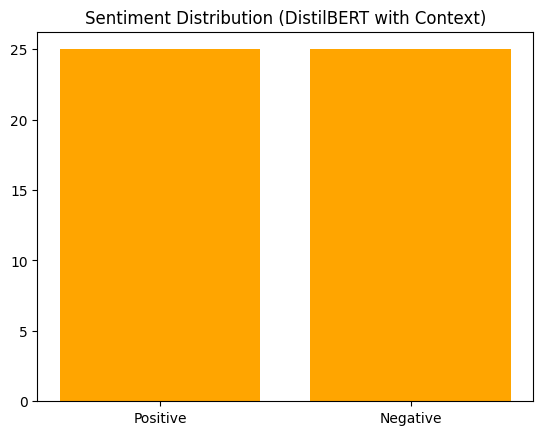

In [ ]:
fig, ax = plt.subplots()
ax.bar(sst_counts.keys(), sst_counts.values(), color="orange")
ax.set_title("Sentiment Distribution (DistilBERT with Context)")
plt.show()


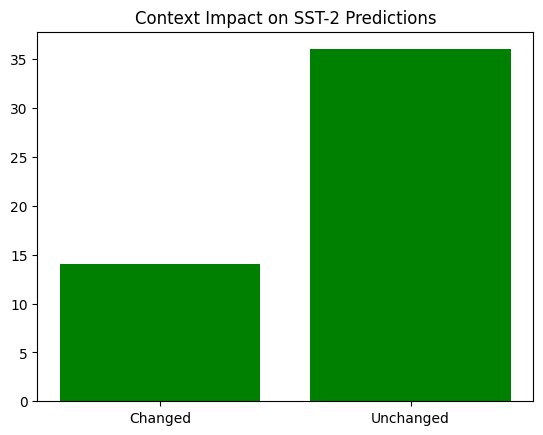

In [ ]:
fig, ax = plt.subplots()
ax.bar(context_effect.keys(), context_effect.values(), color="green")
ax.set_title("Context Impact on SST-2 Predictions")
plt.show()


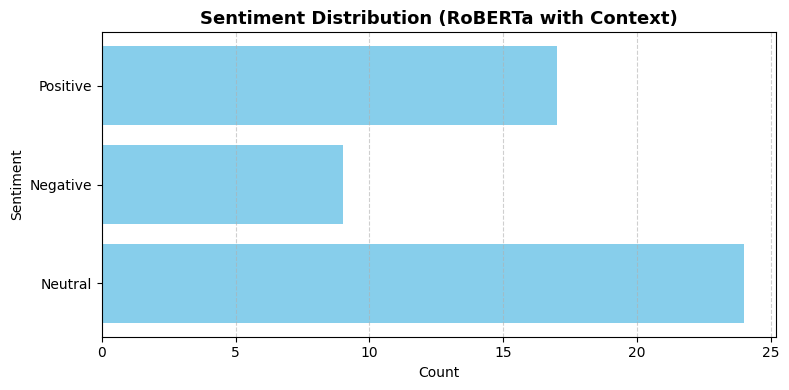

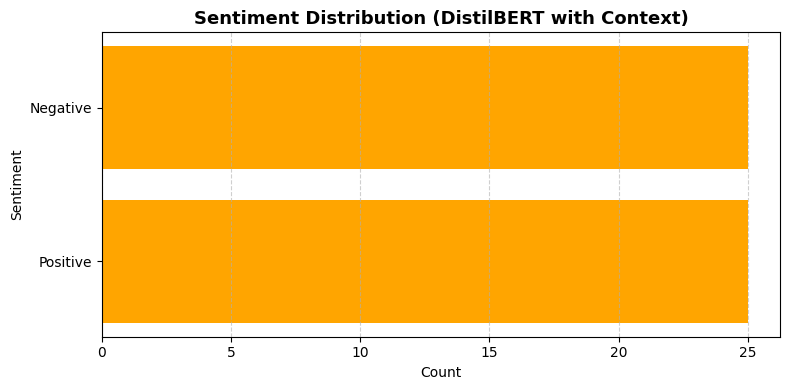

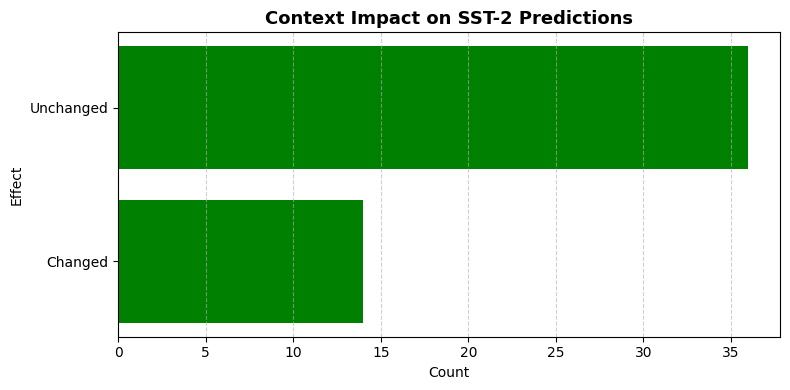

In [ ]:
# --- RoBERTa Sentiment Distribution (horizontal) ---
plt.figure(figsize=(8, 4))
plt.barh(list(roberta_counts.keys()), list(roberta_counts.values()), color="skyblue")
plt.xlabel("Count")
plt.ylabel("Sentiment")
plt.title("Sentiment Distribution (RoBERTa with Context)", fontsize=13, fontweight="bold")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- DistilBERT Sentiment Distribution (horizontal) ---
plt.figure(figsize=(8, 4))
plt.barh(list(sst_counts.keys()), list(sst_counts.values()), color="orange")
plt.xlabel("Count")
plt.ylabel("Sentiment")
plt.title("Sentiment Distribution (DistilBERT with Context)", fontsize=13, fontweight="bold")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- Context Effect Comparison (horizontal) ---
plt.figure(figsize=(8, 4))
plt.barh(list(context_effect.keys()), list(context_effect.values()), color="green")
plt.xlabel("Count")
plt.ylabel("Effect")
plt.title("Context Impact on SST-2 Predictions", fontsize=13, fontweight="bold")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [1]:
context_effect = {"Changed": 0, "Unchanged": 0}
...
if sentiment_response != sentiment_combined:
    context_effect["Changed"] += 1
else:
    context_effect["Unchanged"] += 1


NameError: name 'sentiment_response' is not defined

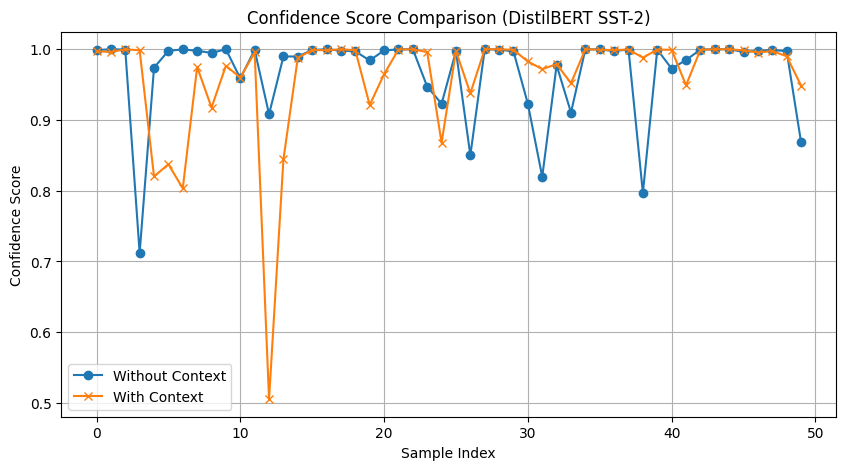

In [ ]:
#Confidence Score Comparison Plot
# To see how confident the model is with vs. without context (for SST-2 model):

response_scores = []
combined_scores = []

for i in range(50):
    context = dataset[i]["context"]
    response = dataset[i]["response"]
    combined = f"{context} [SEP] {response}"

    score_resp = model2(response)[0]["score"]
    score_comb = model2(combined)[0]["score"]

    response_scores.append(score_resp)
    combined_scores.append(score_comb)

# Plot
plt.figure(figsize=(10,5))
plt.plot(response_scores, label="Without Context", marker='o')
plt.plot(combined_scores, label="With Context", marker='x')
plt.title("Confidence Score Comparison (DistilBERT SST-2)")
plt.xlabel("Sample Index")
plt.ylabel("Confidence Score")
plt.legend()
plt.grid(True)
plt.show()


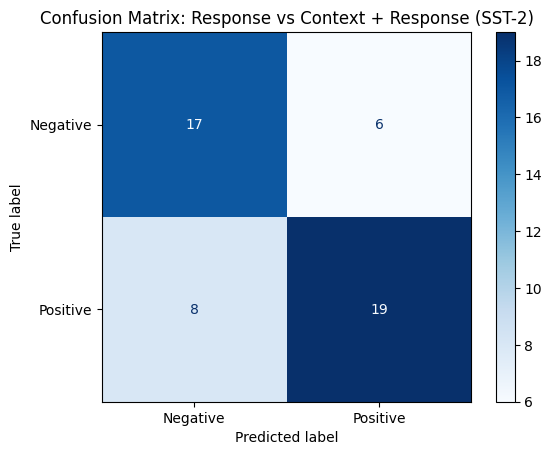

In [ ]:
#Confusion Matrix (Context Shift Categories)
# To quantify how many examples shifted from Negative to Positive, Neutral to Negative, etc.

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

true_labels = []
pred_labels = []

for i in range(50):
    response = dataset[i]["response"]
    context = dataset[i]["context"]
    combined = f"{context} [SEP] {response}"

    res_label = map_sst[model2(response)[0]["label"]]
    comb_label = map_sst[model2(combined)[0]["label"]]

    true_labels.append(res_label)
    pred_labels.append(comb_label)

cm = confusion_matrix(true_labels, pred_labels, labels=["Negative", "Positive"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix: Response vs Context + Response (SST-2)")
plt.show()


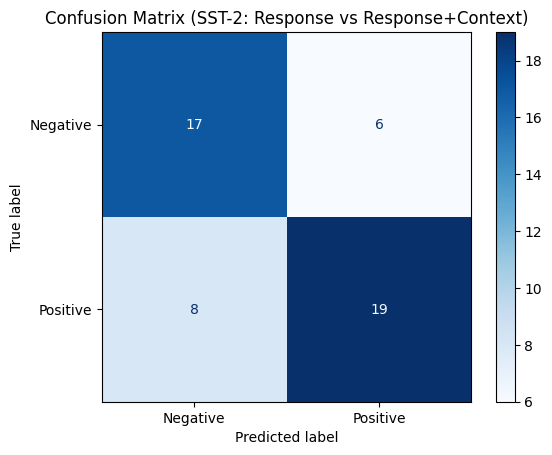

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

true_labels = []
pred_labels = []

for i in range(50):
    context = dataset[i]["context"]
    response = dataset[i]["response"]
    combined = f"{context} [SEP] {response}"

    true = model2(response)[0]["label"]
    pred = model2(combined)[0]["label"]

    true_labels.append(true)
    pred_labels.append(pred)

# Map SST labels to string
true_labels = [map_sst[l] for l in true_labels]
pred_labels = [map_sst[l] for l in pred_labels]

cm = confusion_matrix(true_labels, pred_labels, labels=["Negative", "Positive"])
disp = ConfusionMatrixDisplay(cm, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (SST-2: Response vs Response+Context)")
plt.show()


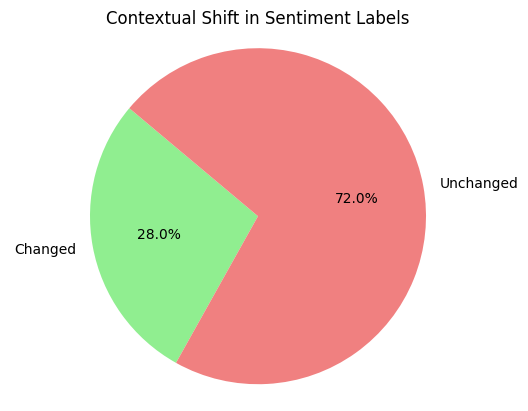

In [ ]:
# Pie Chart of Context Impact
# To show what percentage of predictions changed with context:

plt.pie(
    context_effect.values(),
    labels=context_effect.keys(),
    autopct='%1.1f%%',
    colors=["lightgreen", "lightcoral"],
    startangle=140
)
plt.title("Contextual Shift in Sentiment Labels")
plt.axis("equal")
plt.show()

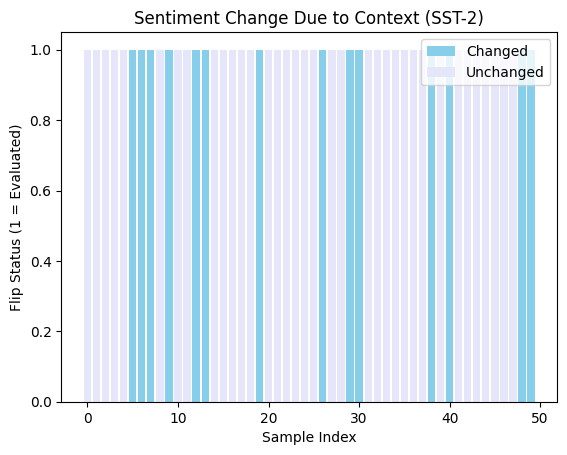

In [ ]:
# Visualize which samples flipped sentiment

flip_indices = [i for i, changed in enumerate(sentiment_changed) if changed]
no_flip_indices = [i for i, changed in enumerate(sentiment_changed) if not changed]

plt.bar(flip_indices, [1]*len(flip_indices), color="skyblue", label="Changed")
plt.bar(no_flip_indices, [1]*len(no_flip_indices), color="lavender", label="Unchanged")
plt.xlabel("Sample Index")
plt.ylabel("Flip Status (1 = Evaluated)")
plt.title("Sentiment Change Due to Context (SST-2)")
plt.legend()
plt.show()
